In [1]:
%matplotlib widget
from helper import *

<div style="font-family: 'Helvetica Neue', Arial, sans-serif;padding: 10px; text-align: center;">


<div style="margin-top: 10px; display: flex;">
    <div style="max-width: 500px; margin-right: auto">
        <img src="./Resources/neura_logo_black.png" alt="Neura Robotics Logo" style="max-width: 100%; height: auto; object-fit: contain;">
    </div>
    <div style="max-width: 600px; margin-left: auto">
        <img src="./Resources/rwth_igmr_de_rgb.png" alt="Neura Robotics Logo" style="max-width: 100%; height: auto; object-fit: contain;">
    </div>
</div>   
<div style="font-family: 'Helvetica Neue', Arial, sans-serif; max-width: 1500px; margin-left: auto; margin-right: auto ">
<h2 style = "text-align: center">Exploiting Redundancies with Predictive Differential Kinematics in Dual-Quaternion-Space for Configuration-optimized and Singularity-robust Trajectory Tracking</h2>
</div>

<div style="margin-bottom: 40px;">
    <!-- Using the logo from the data folder and making it bigger -->
    <img src="./Resources/maira.png" alt="Neura Robotics Logo" style="max-width: 1800px; width: 100%;">
</div>

</div>

# Problem Statement
---
$ q = (\cos\left(\frac{\theta}{2}\right), \sin\left(\frac{\theta}{2}\right)\hat{\mathbf{n}}) $


# Dual Quaternions
---
Three-dimensional rigid transformations are usually represented by homogeneous transformation matrices $T \in \mathcal{SE}(3)$. The *Special Euclidean Group* $\mathcal{SE}(3)$ is given by the semi-direct product of rotation matrices and translation vectors:

$$
\mathcal{SE}(3) = \mathcal{SO}(3) \ltimes \mathbb{R}^{3}
$$

The unit *Dual Quaternion Space* is then given by the semi-direct product of $\mathcal{S}^3$ and $\mathbb{R}^{3}$: 

$$
\mathbb{H} = \mathcal{S}^3 \ltimes \mathbb{R}^{3}
$$

With the space of unit quaternions $\mathcal{S}^3$ and the translation vectors $\mathbb{R}^{3}$.

# Dual Quaternions
---
A unit dual quaternion $\underline{\xi} \in \mathbb{H}$ can be written as

$$
\underline{\xi} = \hat{r} + \epsilon \frac{1}{2}\bar{t} \otimes \hat{r}
$$

where:
- unit quaternion $\hat{r} \in \mathcal{S}^3$
- pure quaternion $\bar{t} \in \mathbb{R}^{3}$
- dual unit $\epsilon$, with $\epsilon^2 = 0$ and  $\epsilon \neq 0$.

In [2]:
r = Quaternion(0.7071, 0.7071, 0, 0)
t = Quaternion(0, 1, 2, 0)

dual_quaternion = DualQuaternion(r, 0.5*t*r)
print(dual_quaternion)

DualQuaternion(Real: Quaternion(0.707, 0.707, 0.000, 0.000), Dual: Quaternion(-0.354, 0.354, 0.707, -0.707))


# Dual Quaternions: Advantages
---

Dual Quaternions inherit benefitial properties from the quaternions. 

These properties include:
- The **Double Cover Property** (or *Antipodal Property*)
- The **Singularity Free Representation**
- The **High Efficiency** in representing transformations

In [2]:
#Example: Antipodal Property
q_start = Quaternion(1,0,0,0)
q_target = Quaternion(.900, 0.150, 0.000, 0.15).normalize()
q_target_antipodal = -1.0*q_target

fig, ax = create_3d_plot(q_target)

s_slider = create_slider("s", 0, 0, 1)
x_axis1, y_axis1, z_axis1 = draw_frame(ax, [0,0,0], q_start.asRotationMatrix())
x_axis2, y_axis2, z_axis2 = draw_frame(ax, [0,0,0], q_start.asRotationMatrix())

def update_plot(change):
    global x_axis1, y_axis1, z_axis1
    global x_axis2, y_axis2, z_axis2
    
    x_axis1.remove()
    y_axis1.remove()
    z_axis1.remove()

    x_axis2.remove()
    y_axis2.remove()
    z_axis2.remove()
    
    q_interpolated1 = Quaternion.slerp(q_start, q_target, s_slider.value)    
    q_interpolated2 = Quaternion.slerp(q_start, q_target_antipodal, s_slider.value)  
    
    x_axis1, y_axis1, z_axis1 = draw_frame(ax, [0,0,0], q_interpolated1.asRotationMatrix())
    x_axis2, y_axis2, z_axis2 = draw_frame(ax, [0,0,0], q_interpolated2.asRotationMatrix())

    fig.canvas.draw()
    fig.canvas.flush_events()

    
s_slider.observe(update_plot, names = 'value')

widgets.AppLayout(
    center=fig.canvas,
    footer=widgets.VBox([s_slider]),
    pane_heights=[0, 3, 1]
)

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, description='s', layout=Layout(width='98%'), max=1.0…

# Dual Quaternions: Effeciency Advantages
---

<a id="table52"></a>
<table>
    <thead>
      <tr>
        <th>Computation</th>
        <th>Storage</th>
        <th>Multiplications</th>
        <th>Additions</th>
        <th>Sin/Cos Evaluations</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Denavit-Hartenberg Tf.</td>
        <td>$16$</td>
        <td>$6$</td>
        <td>$0$</td>
        <td>$4$</td>
      </tr>
      <tr>
        <td>Dual Quaternion Tf.</td>
        <td>$8$</td>
        <td>$15$</td>
        <td>$3$</td>
        <td>$2$</td>
      </tr>
      <tr>
        <td>Dual Quaternion Tf. (revolute)</td>
        <td>$8$</td>
        <td>$7$</td>
        <td>$0$</td>
        <td>$2$</td>
      </tr>
      <tr>
        <td>Tf. Matrix Multiplication</td>
        <td>$-$</td>
        <td>$64$</td>
        <td>$48$</td>
        <td>$0$</td>
      </tr>
      <tr>
        <td>Dual Quaternion Multiplication</td>
        <td>$-$</td>
        <td>$48$</td>
        <td>$40$</td>
        <td>$0$</td>
      </tr>
      <tr>
        <td>DH Forward Kinematics 7DoF</td>
        <td>$112$</td>
        <td>$490$</td>
        <td>$336$</td>
        <td>$28$</td>
      </tr>
      <tr>
        <td>DQ Forward Kinematics 7DoF</td>
        <td>$56$</td>
        <td>$441$</td>
        <td>$301$</td>
        <td>$14$</td>
      </tr>
      <tr>
        <td>DQ Forward Kinematics 7DoF (revolute)</td>
        <td>$56$</td>
        <td>$385$</td>
        <td>$280$</td>
        <td>$14$</td>
      </tr>
    </tbody>
  </table>
  
<p style="text-align:center"><strong>Table 5.2</strong>: Operation count comparison between dual quaternion and Denavit-Hartenberg transformation, transformation matrix and dual quaternion multiplication and the forward kinematics, respectively. </p>


# Dual Quaternions: Screw Transformation
---
<div style="font-family: 'Helvetica Neue', Arial, sans-serif; display: flex; justify-content: space-between;">

<!-- Left column for text -->
<div style="width: 48%;">

The screw axis $\vec{s} \in \mathbb{R}^6$ is defined from a unit rotation axis $\tilde{r}$ and a position $\vec{p}$

$$ 
\vec{s} = (\tilde{r}, \vec{p} \times \tilde{r}) = (\tilde{r}, \vec{m})
$$

Here, $\vec{m} = \vec{p} \times \tilde{r}$ is called the moment of the line.

As exponent for the screw transformation, the screw axis is often represented by the respective *Pure Dual Quaternion* $\underline{\bar{s}} = (0, \tilde{r}) + \epsilon (0, \vec{m}).$
    
</div>

<!-- Right column for image -->
<div style="width: 48%;">
    <img src="./Resources/screw.png" alt="calibration scheme" style="max-width: 500px; width: 100%; display: block; margin-left: auto; margin-right: auto;margin-top: 100px;">
    <p style="text-align: center; font-style: italic; margin-top: 10px;">Screw Axis example.</p>
</div>

# Dual Quaternions: Screw Transformation
---
A unit dual quaternion $ \underline{\xi} $ can then be computed from screw parameters with exponential mapping:

$$
\underline{\xi} = e^{\frac{\underline{\theta}}{2}\bar{\underline{s}}} = \cos(\frac{\underline{\theta}}{2}) + \bar{\underline{s}} \sin(\frac{\underline{\theta}}{2})
$$

with dual angle $\underline{\theta} = \theta + \epsilon d$ and pure dual quaternion (dual vector) $\bar{\underline{s}} = (0,\tilde{r}) + \epsilon (0,\vec{m})$.

dual angle:

- $\theta$: Angle of rotation around screw axis
- $d$: translation along screw axis ($d = 0$ for revolute joints)


In [3]:
fig, ax = create_3d_plot()

quaternion_display = create_textbox("screw")

angle_slider = create_slider("theta", 0, -2*np.pi, 2*np.pi)
azimuth_slider = create_slider("azimuth", 0.5, -2*np.pi, 2*np.pi)
elevation_slider = create_slider("elevation",1.2, -np.pi, np.pi)

x_slider = create_slider("x", .2, -1, 1)
y_slider = create_slider("y", .3, -1, 1)
z_slider = create_slider("z", 0, -1, 1)

rotation_axis = create_quiver(ax, [0,0,0], [1,0,0], 1, 'grey', "rotation_axis")
x_axis2, y_axis2, z_axis2 = draw_frame(ax, [0.1,.2,.1], np.eye(3))
dq_frame = DualQuaternion.fromQuatPos(Quaternion(1,0,0,0), [0.1,.2,.1])

rot_axis = ax.plot([-2, 2], [0,0], [0,0], "--", linewidth = 1, c = "k")
moment = ax.plot([0,0], [0,0], [0,0], "--", linewidth = 1, c = "k")

# Update function for the sliders
def update_plot(change):

    global rotation_axis, x_axis2, y_axis2, z_axis2, rot_axis, moment
    rotation_axis.remove()
    x_axis2.remove()
    y_axis2.remove()
    z_axis2.remove()
    rot_axis[0].remove()
    moment[0].remove()
    
    direction = spherical_coordinates(azimuth_slider.value, elevation_slider.value)
    
    # set position vector
    pos = [x_slider.value, y_slider.value, z_slider.value]
    
    screw_axis = DualQuaternion.screwAxis(*direction, *pos)
    
    theta = angle_slider.value
    d = 0.2*angle_slider.value
   
    exponent = DualQuaternion(screw_axis.real*theta, screw_axis.dual*theta + screw_axis.real*d)
    dq = DualQuaternion.exp(0.5*exponent)*dq_frame
    
    # update displays
    quaternion_display.value = str(screw_axis)
    
    # update the drawn vectors and the arc
    rotation_axis = create_quiver(ax, pos, direction,1, 'grey', "rotation_axis")
    
    rot_axis = ax.plot([pos[0]-direction[0]*2, pos[0]+direction[0]*2], [pos[1]-direction[1]*2, pos[1]+direction[1]*2], [pos[2]-direction[2]*2, pos[2]+direction[2]*2], "--", linewidth = 1, c = "black")
    moment = ax.plot([0, pos[0]], [0, pos[1]], [0, pos[2]], "--", linewidth = 1, c = "k")
 
    x_axis2, y_axis2, z_axis2 = draw_frame(ax, dq.getPosition().flatten(), dq.real.asRotationMatrix()*0.5)
    
    fig.canvas.draw()
    fig.canvas.flush_events()


angle_slider.observe(update_plot, names = 'value')
azimuth_slider.observe(update_plot, names='value')
elevation_slider.observe(update_plot, names='value')
x_slider.observe(update_plot, names='value')
y_slider.observe(update_plot, names='value')
z_slider.observe(update_plot, names='value')

widgets.AppLayout(
    center=fig.canvas,
    footer=widgets.VBox([quaternion_display, angle_slider, azimuth_slider, elevation_slider, x_slider, y_slider, z_slider]),
    pane_heights=[0, 2, 1])

AppLayout(children=(VBox(children=(Text(value='', description='screw', layout=Layout(width='98%')), FloatSlide…

# State of the Art: Online Motion Control
---

<a id="table21"></a>

<table>
    <thead>
      <tr>
        <th style="width: 200px";>Feature</th>
        <th>analytic IK</th>
        <th>iterative IK</th>
        <th>IDK (classic)</th>
        <th>IDK (QP)</th>
        <th>MPC</th>
        <th>NMPC</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>real-time applicable</td>
        <td>yes</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>no</td>
        <td>no</td>
      </tr>
      <tr>
        <td>predictive approach</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>nullspace projection</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>extra constraints</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>locally smooth</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
    </tbody>
  </table>
  
<p style="text-align: center;"><strong>Table 2.1</strong>: Comparison of common inverse kinematic methods.</p>

# State of the Art: Dual Quaternion Interpolation
---

<a id="table22"></a>

<table>
    <thead>
      <tr>
        <th style="width: 200px";>Feature</th>
        <th>DLB</th>
        <th>ScLERP</th>
        <th>SEP(LERP)</th>
        <th>Bezier</th>
        <th>SCB</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>decoupled interpolation</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>-</td>
      </tr>
      <tr>
        <td>multipoint interpolation</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>definable motion profiles</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
        <td>no</td>
        <td>-</td>
      </tr>
      <tr>
        <td>constant velocity</td>
        <td>no</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>$\mathcal{C}^2$ continuity</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>no</td>
        <td>yes</td>
      </tr>
      <tr>
        <td>translation interpolation</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>no</td>
      </tr>
      <tr>
        <td>orientation interpolation</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
        <td>yes</td>
      </tr>
    </tbody>
  </table>
  
  <p style="text-align: center"><strong>Table 2.2</strong>: Comparison of common dual quaternion interpolation methods</p>

# Dual Quaternion Interpolation: Proposed Method DQQB
---

- multi-point interpolation in the dual quaternion space with definable motion primitives (line, arc)
- can make use of the benefits dual quaternionic contemplation
- provides smooth, velocity, acceleration, and jerk limited trajectories for rotational and translational motion
- Publication currently under review, for further details see: https://github.com/JTem/Dual-Quaternion-Quintic-Blends

In [4]:
# define orientation quaternions for test trajectory
q1 = Quaternion(0.454, -0.891, -0.000, -0.000)
q2 = Quaternion(0.321, -0.630, -0.630, 0.321)
q3 = Quaternion(0.219, -0.219, -0.672, 0.672)

# define dual quaternions for linear interpolation
dq1 = DualQuaternion.fromQuatPos(q1, np.array([-0.4, 0, 0]))
dq2 = DualQuaternion.fromQuatPos(q1, np.array([0, 0, 0 ]))
dq3 = DualQuaternion.fromQuatPos(q2, np.array([0, 0, 0 ]))
dq4 = DualQuaternion.fromQuatPos(q3, np.array([0, 0.3, 0 ]))

print(dq1)
print(dq2)
print(dq3)
print(dq4)

# assign dual quaternions to lists
line_DQ_list = [dq1, dq2, dq3, dq4]

# initialize line and arc generators
line_generator = LineGenerator()

# define desired cartesian velocites and maximum angular velocity
des_cart_vel_line = 0.5
max_ang_vel = 1

# generate segments
line_segments = line_generator.generateSegments(line_DQ_list, des_cart_vel_line, max_ang_vel)

# merge segments into one segment list
segments = line_segments

DualQuaternion(Real: Quaternion(0.454, -0.891, -0.000, -0.000), Dual: Quaternion(-0.178, -0.091, 0.000, 0.000))
DualQuaternion(Real: Quaternion(0.454, -0.891, -0.000, -0.000), Dual: Quaternion(0.000, 0.000, 0.000, 0.000))
DualQuaternion(Real: Quaternion(0.321, -0.630, -0.630, 0.321), Dual: Quaternion(0.000, 0.000, 0.000, 0.000))
DualQuaternion(Real: Quaternion(0.219, -0.219, -0.672, 0.672), Dual: Quaternion(0.101, 0.101, 0.033, 0.033))


In [5]:
# define the acceleration and jerk limits
a_cart_max = 1
j_cart_max = 10
a_ang_max = 2
j_ang_max = 15

# generate trajectory object with the segments defined above
trajectory = DQQBTrajectoryGenerator()

trajectory.generateDynamicTrajectory(segments, a_cart_max, j_cart_max, a_ang_max, j_ang_max)

iteration:  1
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
acceleration limit violated!
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


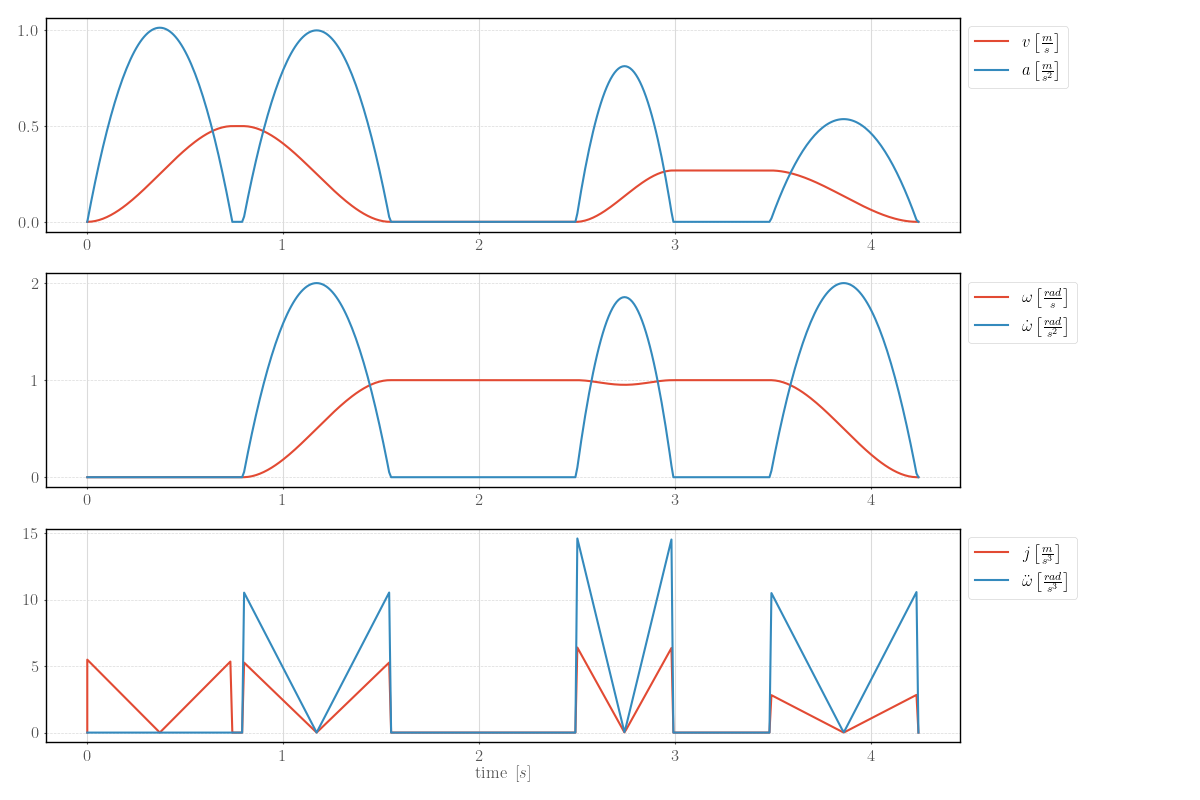

In [6]:
time_vec = np.arange(0, trajectory.time_vector[-1]+0.01, 0.01)

time = [0]
vel_norm_list = [0]
acc_norm_list = [0]
jerk_norm_list = [0]

ang_vel_norm_list = [0]
ang_acc_norm_list = [0]
ang_jerk_norm_list = [0]

quaternion_list = []

x = []
y = []
z = []

for t in time_vec:
    time.append(t)
    pos, vel, acc, jerk, quaternion, ang_vel, ang_acc, ang_jerk = trajectory.evaluate(t)
    
    if t == time_vec[-1]:
        vel_norm_list.append(0)
        acc_norm_list.append(0)
        jerk_norm_list.append(0)

        ang_vel_norm_list.append(0)
        ang_acc_norm_list.append(0)
        ang_jerk_norm_list.append(0)
    else:
        vel_norm_list.append(np.linalg.norm(vel))
        acc_norm_list.append(np.linalg.norm(acc))
        jerk_norm_list.append(np.linalg.norm(jerk))

        ang_vel_norm_list.append(np.linalg.norm(ang_vel))
        ang_acc_norm_list.append(np.linalg.norm(ang_acc))
        ang_jerk_norm_list.append(np.linalg.norm(ang_jerk))
    
    quaternion_list.append(quaternion)
    
    x.append(pos[0])
    y.append(pos[1])
    z.append(pos[2])

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
text_size = 12
plt.rcParams['font.size'] = text_size  # Adjust this value as needed
plt.rcParams['axes.labelsize'] = text_size  # For x and y labels
plt.rcParams['xtick.labelsize'] = text_size  # For x tick labels
plt.rcParams['ytick.labelsize'] = text_size  # For y tick labels
plt.rcParams['legend.fontsize'] = text_size  # For legend


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

ax1.plot(time, vel_norm_list, linewidth=1.5, label = r'$v \left[ \frac{m}{s} \right]$')
ax1.plot(time, acc_norm_list, linewidth=1.5, label = r'$a \left[ \frac{m}{s^2} \right]$')
ax1.set_yticks(np.arange(0, 1 + 0.5, 0.5))
ax1.legend()

ax2.plot(time, ang_vel_norm_list, linewidth=1.5, label = r'$\omega \left[ \frac{rad}{s} \right]$')
ax2.plot(time, ang_acc_norm_list, linewidth=1.5, label = r'$\dot{\omega} \left[ \frac{rad}{s^2} \right]$')
ax2.set_yticks(np.arange(0, 2 + 1, 1))
ax2.legend()

ax3.plot(time, jerk_norm_list, linewidth=1.5, label =r'$j \left[ \frac{m}{s^3} \right]$')
ax3.plot(time, ang_jerk_norm_list, linewidth=1.5, label = r'$\ddot{\omega} \left[ \frac{rad}{s^3} \right]$')
ax3.set_yticks(np.arange(0, 15 + 5, 5))
ax3.set_xlabel(r'$\textrm{time } \left[ s \right]$')
ax3.legend()

# Place the legends outside the plot on the right side
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax3.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Enable grid
ax1.grid(True, axis='y', which='both', linestyle='--', linewidth=0.5)
ax2.grid(True, axis='y', which='both', linestyle='--', linewidth=0.5)
ax3.grid(True, axis='y', which='both', linestyle='--', linewidth=0.5)

# Adjust the layout
plt.tight_layout()

# To avoid clipping of the legend, adjust the subplot parameters
plt.subplots_adjust(right=0.8)  # Adjust this value based on your layout

plt.show() 

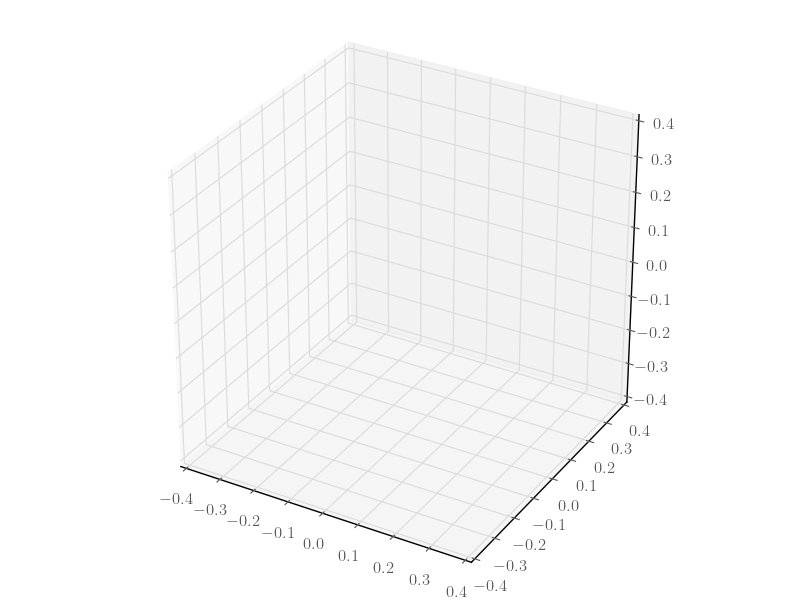

In [7]:
#plt.rc('text', usetex=False)
# Create a new figure for the 3D plot
fig_3d = plt.figure(figsize=(8, 6))

# Create 3D axes
ax_3d = fig_3d.add_subplot(111, projection='3d')
fig_3d.canvas.header_visible = False
size = 0.4
ax_3d.set_xlim([-size, size])
ax_3d.set_ylim([-size, size])
ax_3d.set_zlim([-size, size])
ax_3d.set_box_aspect([1, 1, 1])
plt.tight_layout()
# Define the update function for the animation
def update(frame):
    ax_3d.cla()  # Clear the previous plot
    ax_3d.set_xlim([-size, size])
    ax_3d.set_ylim([-size, size])
    ax_3d.set_zlim([-size, size])
    ax_3d.set_box_aspect([1, 1, 1])
    ax_3d.set_facecolor('white')
    ax_3d.set_axis_off()
    for spine in ax_3d.spines.values():
        spine.set_visible(False)
        
    # Draw the trajectory
    ax_3d.plot(x, y, z, label='Trajectory')
    
    # Draw the dot at the current position
    #ax_3d.scatter(x[frame], y[frame], z[frame], color='red')
    
    R = quaternion_list[frame].asRotationMatrix()*0.15
    # Draw coordinate frame (quiver arrows)
    #x_axis = ax.quiver(*start_point, *R[:,0], arrow_length_ratio = 0.1, linewidth = 1, color='r')
    ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,0], color='red', label='X')
    ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,1], color='green', label='Y')
    ax_3d.quiver(x[frame], y[frame], z[frame], *R[:,2], color='blue', label='Z')
    
    # Set labels and legend
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_3d.legend()

# Create the FuncAnimation object with a smaller interval for faster animation
ani = animation.FuncAnimation(fig_3d, update, frames=len(x), repeat=False, interval=0.01)

# Display the animation
plt.show()

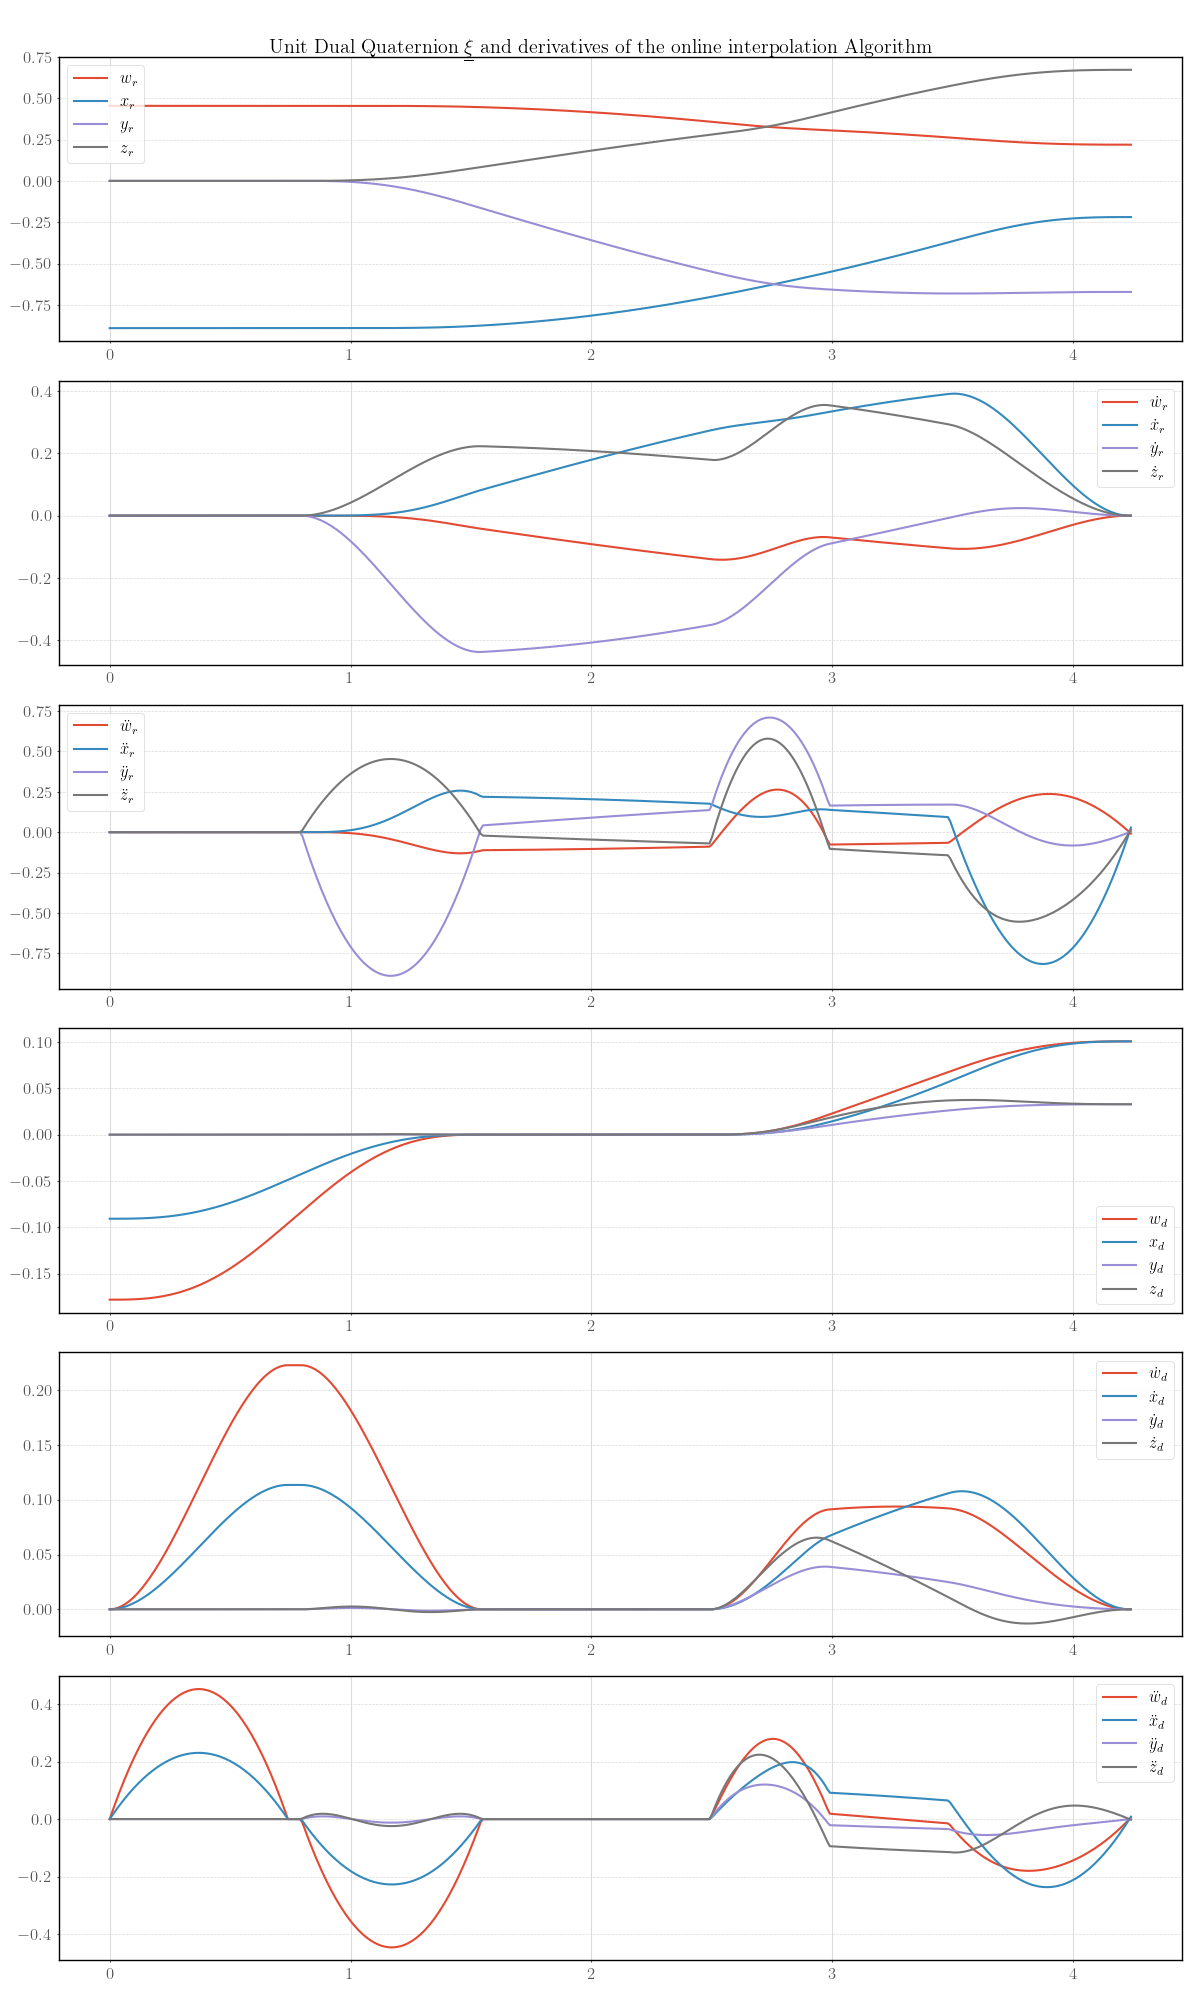

In [8]:
ime_vec = np.arange(0.01, trajectory.time_vector[-1]+0.01, 0.01)

dqr_list = []
dqr_dot_list = []
dqr_ddot_list = []

dqd_list = []
dqd_dot_list = []
dqd_ddot_list = []

for t in time_vec:
    
    dq, dq_dot, dq_ddot = trajectory.evaluateDQ(t)
    
    dqr_list.append(dq.real.asVector().flatten())
    dqr_dot_list.append(dq_dot.real.asVector().flatten())
    dqr_ddot_list.append(dq_ddot.real.asVector().flatten())
    
    dqd_list.append(dq.dual.asVector().flatten())
    dqd_dot_list.append(dq_dot.dual.asVector().flatten())
    dqd_ddot_list.append(dq_ddot.dual.asVector().flatten())

    
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(12, 20))
fig.suptitle(r"Unit Dual Quaternion $\underline{\xi}$ and derivatives of the online interpolation Algorithm")

ax1.plot(time_vec, dqr_list, linewidth=1.5, label = ["$w_r$", "$x_r$", "$y_r$", "$z_r$"])
ax1.legend()

ax2.plot(time_vec, dqr_dot_list, linewidth=1.5, label = ["$\dot{w}_r$", "$\dot{x}_r$", "$\dot{y}_r$", "$\dot{z}_r$"])
ax2.legend()

ax3.plot(time_vec, dqr_ddot_list, linewidth=1.5, label = ["$\ddot{w}_r$", "$\ddot{x}_r$", "$\ddot{y}_r$", "$\ddot{z}_r$"])
ax3.legend()


ax4.plot(time_vec, dqd_list, linewidth=1.5, label = ["$w_d$", "$x_d$", "$y_d$", "$z_d$"])
ax4.legend()

ax5.plot(time_vec, dqd_dot_list, linewidth=1.5, label = ["$\dot{w}_d$", "$\dot{x}_d$", "$\dot{y}_d$", "$\dot{z}_d$"])
ax5.legend()

ax6.plot(time_vec, dqd_ddot_list, linewidth=1.5, label = ["$\ddot{w}_d$", "$\ddot{x}_d$", "$\ddot{y}_d$", "$\ddot{z}_d$"])
ax6.legend()

ax1.grid(True,axis='y', which='both', linestyle='--', linewidth=0.5)
ax2.grid(True,axis='y', which='both', linestyle='--', linewidth=0.5)
ax3.grid(True,axis='y', which='both', linestyle='--', linewidth=0.5)
ax4.grid(True,axis='y', which='both', linestyle='--', linewidth=0.5)
ax5.grid(True,axis='y', which='both', linestyle='--', linewidth=0.5)
ax6.grid(True,axis='y', which='both', linestyle='--', linewidth=0.5)

#Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Dual Quaternion Interpolation: DQQB
---

In [9]:
%%HTML
<video width="1100" height="700" controls>
  <source src=".\Resources\example.mov" type="video/mp4">
</video>

# Dual Quaternion Jacobian
---
The relation of the twist and the dual quaternion derivative is recalled for this transformation into the dual quaternion space. 

$$
\begin{align*}
\underline{\dot{\xi}} &= \frac{1}{2} \underline{\bar{\Omega}}_s \otimes \underline{\xi}\\
&= \frac{1}{2} [\underline{\xi}]_R \cdot \underline{\bar{\Omega}}_{s[vec]}
\end{align*}
$$

Substitution of the twist $\vec{\Omega}_s = J_s \dot{\vec{\theta}}$ with the space Jacobian and reformulation yields gives the *Unit Dual Quaternion Jacobian* $J_\mathbb{H}$:

$$
\begin{align*}
\underline{\dot{\xi}} &= \left(\frac{1}{2} [\underline{\xi}]_R J_s \right) \dot{\vec{\theta}}\\
&= J_\mathbb{H}\dot{\vec{\theta}}
\end{align*}
$$

# Predictive Differential Kinematics: Quadratic Formulation
---


$$
\begin{align*}
\min_{x}& \; f(x) = \frac{1}{2} x^T P x + q^T x \\
\textrm{subject to}& \; l \leq Ax \leq u \\
\end{align*}
$$


# Predictive Differential Kinematics: Yoshikawa Manipulability Optimization
---

Yoshikawa manipulability Measure:

$$
m(\theta) = \sqrt{\det \left( J(\theta)J(\theta)^T \right)}
$$

Yoshikawa Manipulability gradient: 

$$
\dot{m}(\theta) = \frac{d m(\theta)}{d\vec{\theta}}\dot{\vec{\theta}} = J_m^T\dot{\vec{\theta}}
$$

with the formulation from Corke and Haviland:

$$
J_m(\theta) = \sqrt{ \det \left( J(\theta)J(\theta)^T \right)}
\begin{bmatrix}
\text{vec}(J(\theta)H_1(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T)^{-1}) \\
\text{vec}(J(\theta)H_2(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T)^{-1}) \\
\vdots & \vdots \\
\text{vec}(J(\theta)H_{DoF}(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T)^{-1})
\end{bmatrix}
$$

# Predictive Differential Kinematics: Directional Manipulability Optimization
---

With the direction which is computed from the dual quaternionic body twist, 

$$
 dir = \left( o_x, o_y, o_z, t_x, t_y, t_z \right) = \underline{\bar{\Omega}}_{b[6vec]} = \left[ \underline{\xi}_{des}^*\otimes \underline{\dot{\xi}}_{des}\right]_{6vec}
$$

The directional Gradient can be computed via weighing and regularization of the classic formulation of the manipulability gradient:

$$
J_{dir}(\theta) = 
\begin{bmatrix}
\text{vec}(\color{red}{W_{dir}}\color{black}{} J(\theta)H_1(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T  + \color{blue}{\lambda I}\color{black}{})^{-1}) \\
\text{vec}(\color{red}{W_{dir}}\color{black}{} J(\theta)H_2(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T + \color{blue}{\lambda I}\color{black}{})^{-1}) \\
\vdots & \vdots \\
\text{vec}(\color{red}{W_{dir}}\color{black}{} J(\theta)H_{DoF}(\theta)^T) & \text{vec}((J(\theta)J(\theta)^T + \color{blue}{\lambda I}\color{black}{})^{-1}) 
\end{bmatrix}
$$

# Predictive Differential Kinematics: Prediction
---

$$
dir_{pred}(t) = \frac{ dir_0 + 2 \sum_{i=0}^{n} \left| \left[ \underline{\xi}_{des}^*(t + i \Delta t)\otimes \underline{\dot{\xi}}_{des}(t + i \Delta t)\right]_{6vec}\right|}{ \left\| dir_0 + 2 \sum_{i=0}^{n} \left[ \underline{\xi}_{des}^*(t + i \Delta t)\otimes \underline{\dot{\xi}}_{des}(t + i \Delta t)\right]_{6vec}\right\|} 
$$


# Predictive Differential Kinematics: proposed Method
---

$$
\begin{align*}
\min_{x} \; f(x) = &\frac{1}{2} 
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix}^T 
\begin{bmatrix}
W_{\dot{\theta}} & 0 & 0\\
0 & W_{\ddot{\theta}} & 0\\
0 & 0 & \lambda_s
\end{bmatrix}
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix} + 
\begin{bmatrix}
(W_p \theta + \lambda_l J_l(\theta) - \lambda_{dir}J_{dir}(\theta, dir))\\
W_v \dot{\theta} \\
-2\lambda_s
\end{bmatrix}^T 
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix}\\
\\
\textrm{subject to}& \; 
\begin{bmatrix}
0_{8 \times 1}\\
\dot{\theta}_{k-1}\\
\dot{\theta}_m\\
-inf\\
0
\end{bmatrix} 
\leq 
\begin{bmatrix}
J_\mathbb{H}(\theta) & 0_{8 \times DoF} &-[\dot{\underline{\xi}}_{des} + k_p\left(\underline{\xi}_{des} - fk(\theta)\right)]_{vec}\\
I_{DoF \times DoF} & -\Delta t I_{DoF \times DoF} & 0_{DoF \times 1}\\
I_{DoF \times DoF} & 0_{DoF \times DoF} & 0_{DoF \times 1}\\
0_{DoF \times DoF} & I_{DoF \times DoF} & 0_{DoF \times 1}\\
0_{1 \times DoF} & 0_{1 \times DoF} & 1\\
\end{bmatrix} 
\begin{bmatrix}
\dot{\theta}\\
\ddot{\theta}\\
s
\end{bmatrix} \leq 
\begin{bmatrix}
0_{8 \times 1}\\
\dot{\theta}_{k-1}\\
\dot{\theta}_M\\
inf\\
1
\end{bmatrix} 
\end{align*}
$$

# Predictive Differential Kinematics: Classical Method
---


In [10]:
fk = ForwardKinematics()

q1 = np.array([deg2rad(0), deg2rad(0), deg2rad(0), deg2rad(90), deg2rad(10), deg2rad(-90), deg2rad(0)])

quat0 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,1,0]))
quat1 = Quaternion.fromAxisAngle(np.pi*0.5, np.array([0,0,1]))

x1 = DualQuaternion.fromQuatPos(quat0, np.array([0.350, 0, 1.138]))
x2 = DualQuaternion.fromQuatPos(quat0, np.array([0.815, 0, 1.138]))
x3 = DualQuaternion.fromQuatPos(quat1*quat0, np.array([0.815, 0, 1.138]))     
x4 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0.815, 0, 1.138]))  
x5 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0, 0, 1.138]))  
x6 = DualQuaternion.fromQuatPos(quat0*quat0, np.array([0, 0.5, 1.138]))  

task_list = np.array([MoveJoint(q1, 2), MoveLinear(fk.getFK(q1), x1, 3), MoveLinear(x1, x2, 4), MoveLinear(x2, x3, 2), WaitTime(1), MoveLinear(x3, x1, 4),
                      MoveLinear(x1, x2, 4), MoveLinear(x2, x4, 2), WaitTime(1)])

sim_classic = Simulation(task_list, method = "classic", browser = "notebook")

sim_classic.start()

# Predictive Differential Kinematics: Proposed Method with Yoshikawa Manipulability Gradient
---


In [11]:
sim_yosh = Simulation(task_list, method = "qp_yoshikawa", browser = "notebook")

sim_yosh.start()

# Predictive Differential Kinematics: Proposed Method with proposed *Directional Manipulability Gradient*
---


In [12]:
sim_qp = Simulation(task_list, method = "qp", browser = "notebook")

sim_qp.start()